In [1]:
# %%
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
#For interactive plots 

import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate, get_movie, get_genre_counts


## Data Loading and processing 


In [ ]:
#loading the inflation rate data set from the columbia bank 
inflation_rate_df=get_inflation_rate()

#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')

#Data frame with all the movies with processing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

# Drop franchises where any movie in the franchise does not have a release date
franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
print("Number of movies with all movies having release dates : ", len(franchise_df_2))

Number of movies with all movies having release dates :  5163


5163 when we drop collections where 1 movie doesn't have release date => confuses the order
5169 when we just drop the movies with missing date and not other movies in the same collection

## Data presentation 

### General numerical analysis 


In [3]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise_df)}")


count    1594.000000
mean        3.242785
std         3.752299
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5169
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


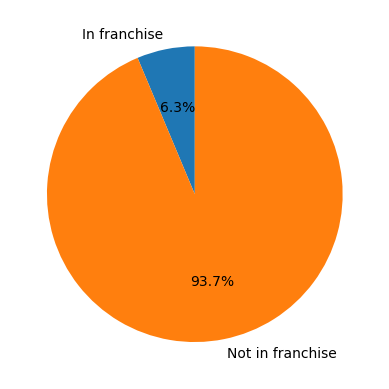

In [4]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

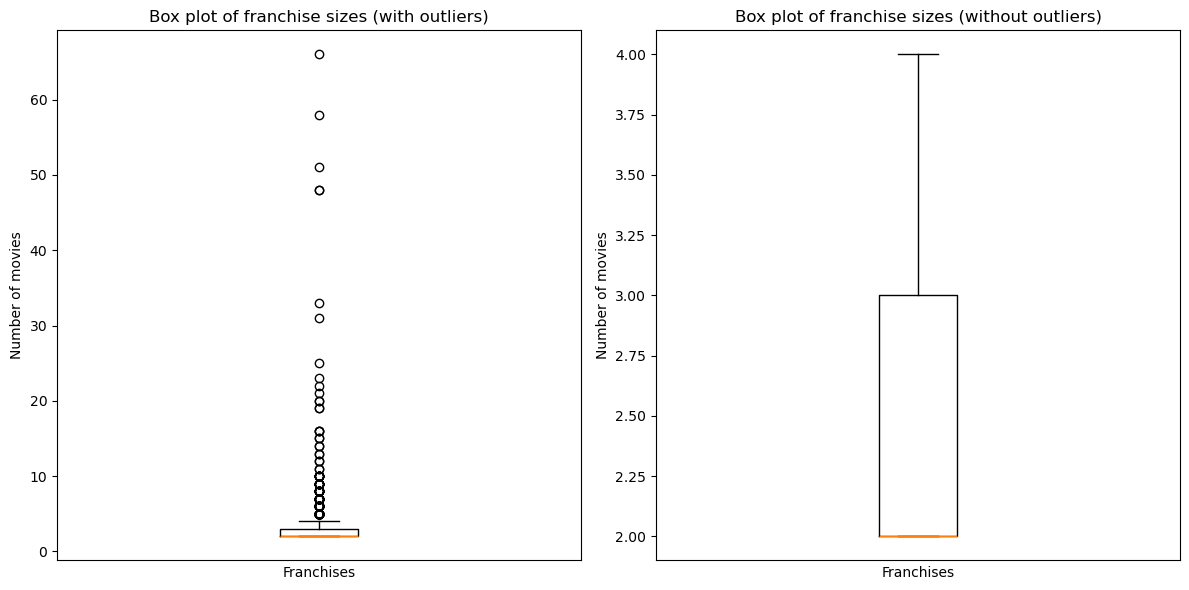

In [5]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

# Univariate Analysis 

## Genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

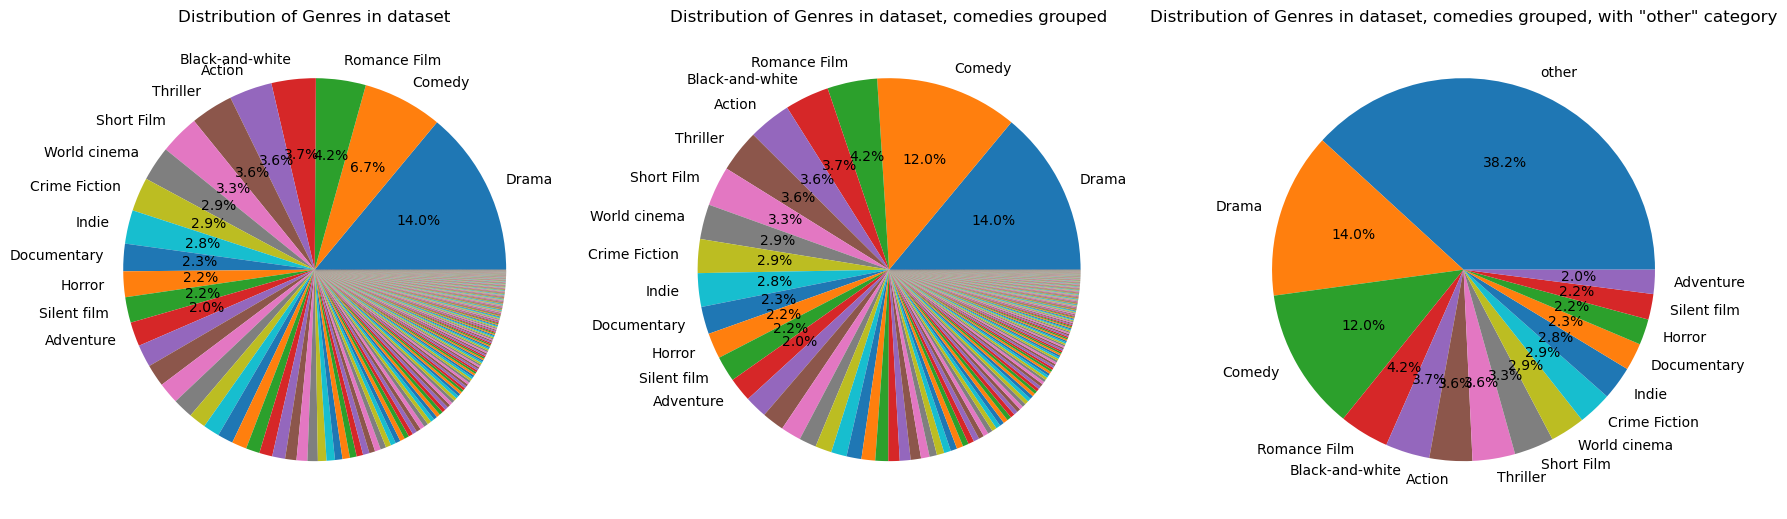

In [6]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(movies_df_raw)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

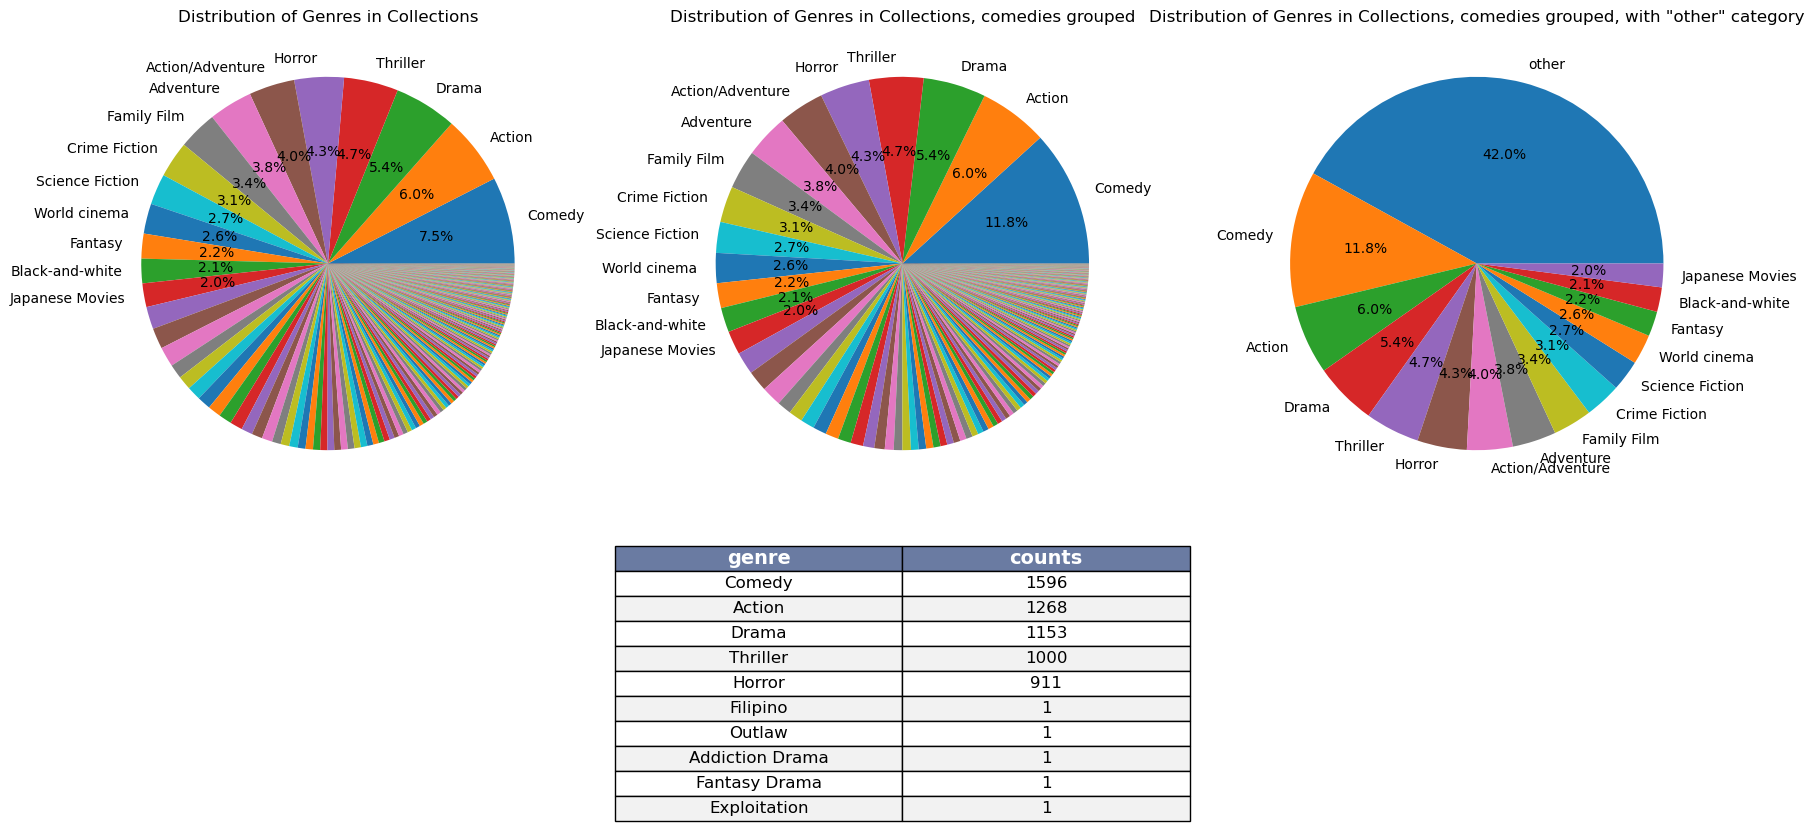

In [7]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(franchise_df)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

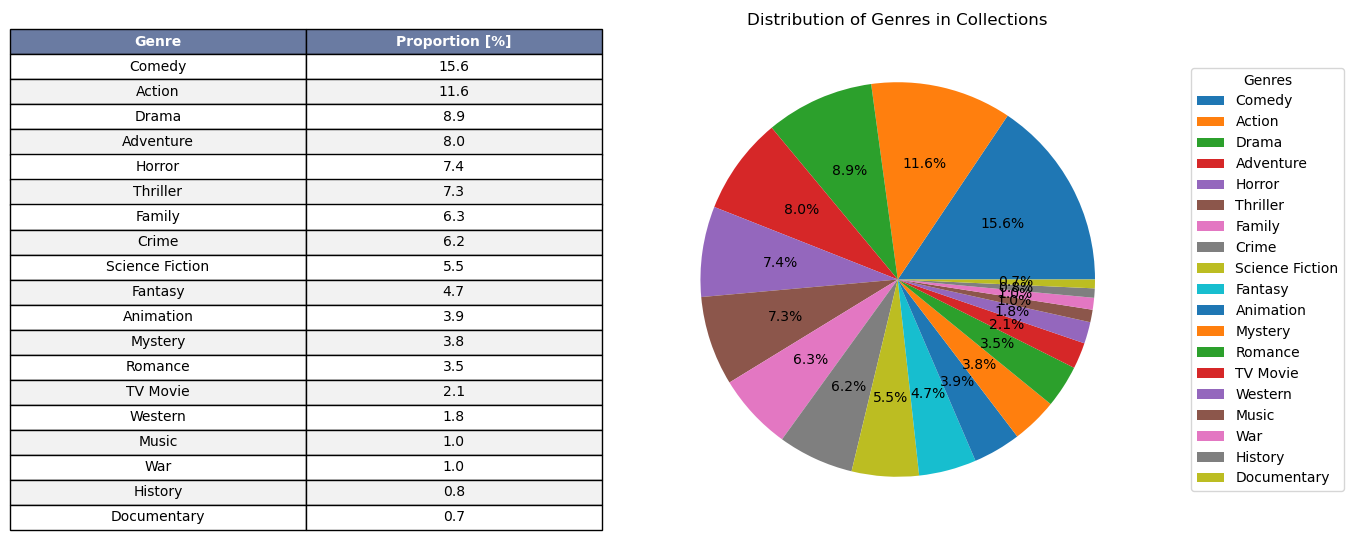

In [8]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

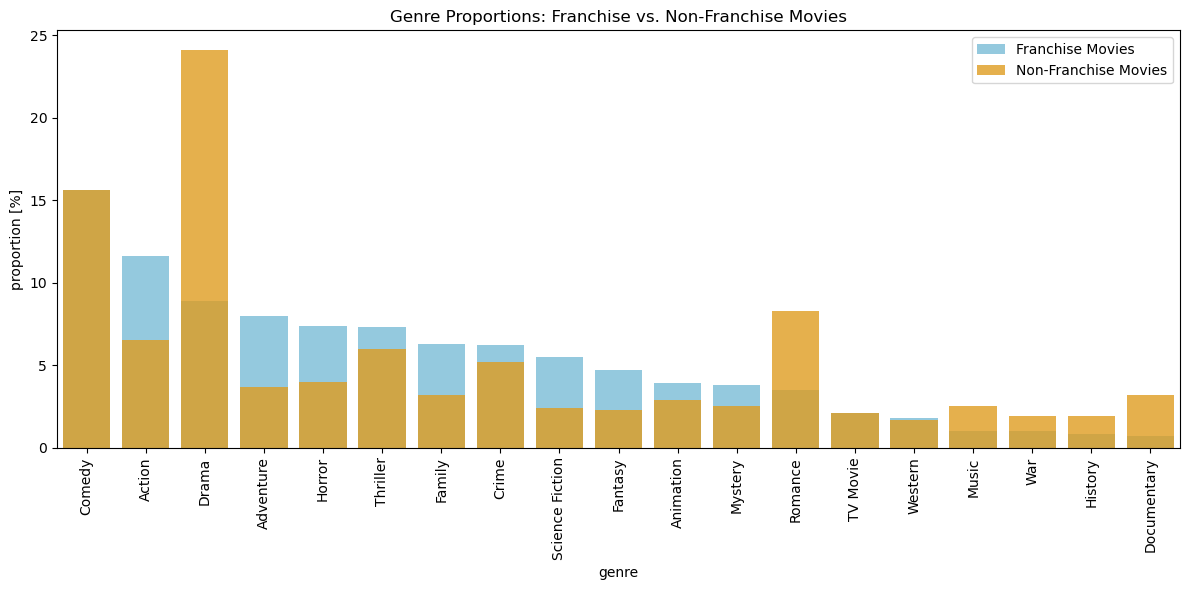

In [9]:
# Extract genres proportions for movies not in franchise, as done before
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()

## Box office 

In [10]:
franchise_revenue = franchise_df.dropna(subset=['real_revenue'])
movies_revenue = movies_df.dropna(subset=['real_revenue']) 
movies_no_franchise_revenue = movies_no_franchise_df.dropna(subset=['real_revenue'])
print(franchise_df['collection_id'].value_counts()) # This indicates that for all franhcise we have at leats 2 movies 

collection_id
564261.0    66
563999.0    58
392686.0    51
435347.0    48
415931.0    48
            ..
44979.0      2
141084.0     2
338416.0     2
561978.0     2
518611.0     2
Name: count, Length: 1594, dtype: int64


       non-franchise movies  franchise movies    all movies
count          6.929000e+03      1.256000e+03  8.400000e+03
mean           5.704675e+07      2.849195e+08  8.763865e+07
std            1.253998e+08      4.601558e+08  2.048312e+08
min            1.825894e+04      2.551028e+04  1.825894e+04
25%            3.195314e+06      2.950505e+07  3.800078e+06
50%            1.407101e+07      1.022562e+08  1.941931e+07
75%            5.269909e+07      3.386860e+08  7.437328e+07
max            3.990258e+09      6.234223e+09  5.080139e+09


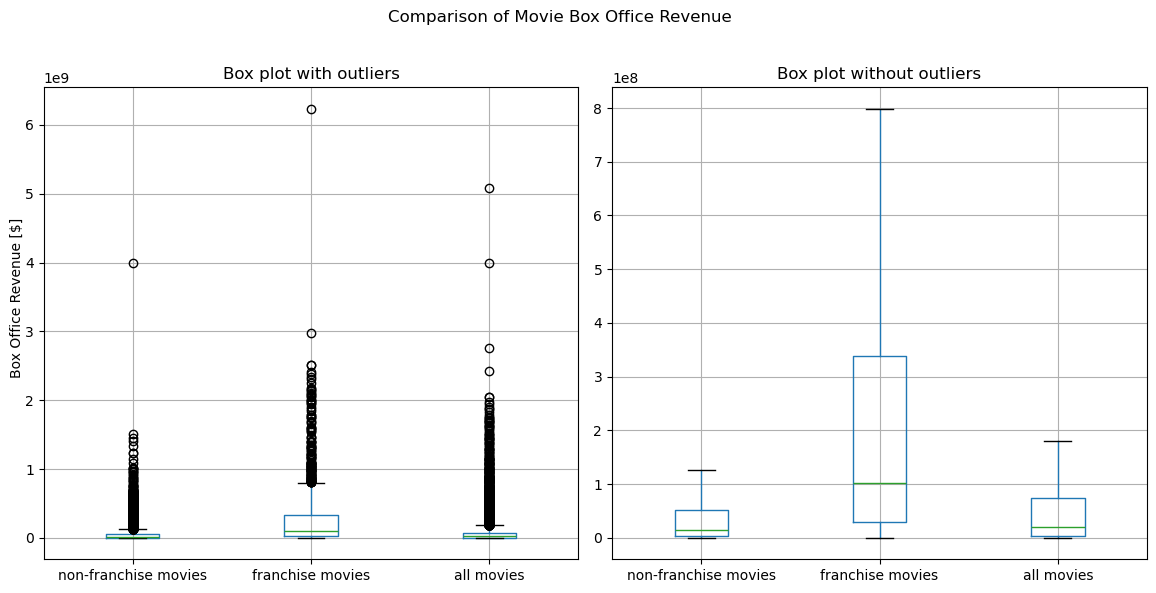

In [11]:
all_revenue= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_revenue'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_revenue'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_revenue']
        })
print(all_revenue.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_revenue.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_revenue.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue ')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

## Movie budget

       non-franchise movies  franchise movies    all movies
count          3.992000e+03      1.028000e+03  5.181000e+03
mean           4.391808e+07      8.059310e+07  4.916370e+07
std            5.133770e+07      1.041650e+08  6.168919e+07
min            9.129469e+00      1.994216e+02  9.129469e+00
25%            9.129469e+06      1.344415e+07  1.004242e+07
50%            2.738841e+07      4.033246e+07  2.738841e+07
75%            5.477681e+07      1.013913e+08  6.390628e+07
max            4.564734e+08      8.492224e+08  6.920137e+08


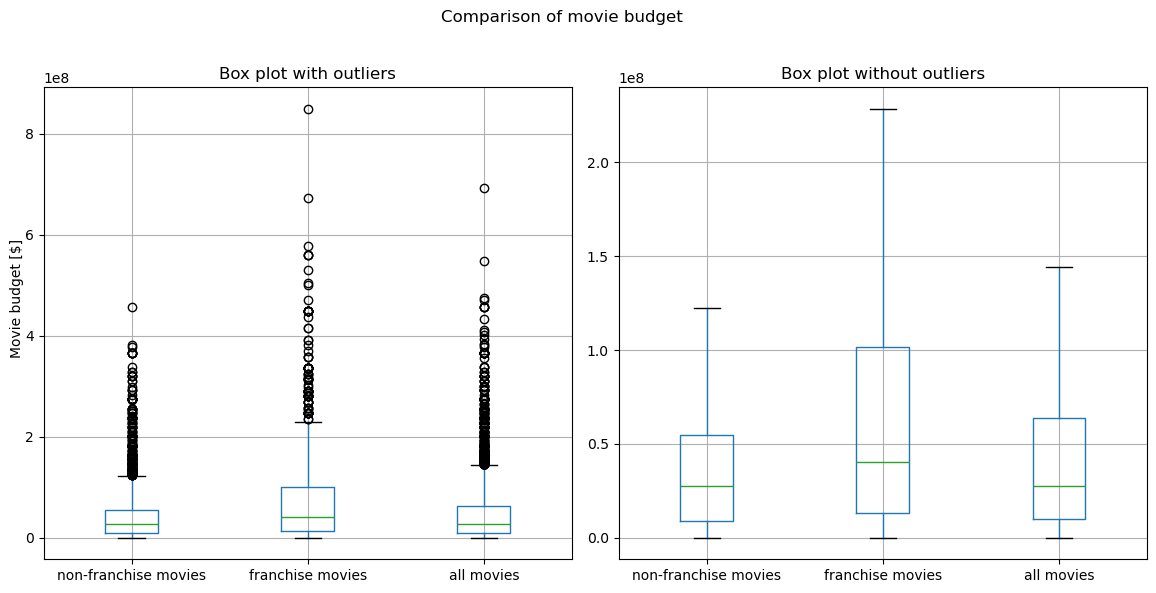

In [12]:
all_budget= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_budget'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_budget'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_budget']
        })
print(all_budget.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_budget.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_budget.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Movie budget [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of movie budget')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

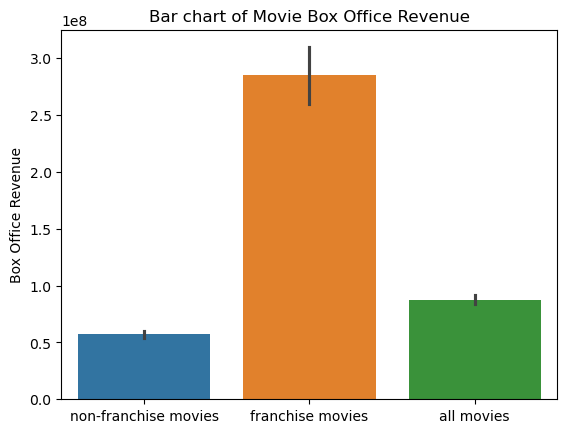

T-test Results:
T-statistic: 17.4333
P-value: 2.8144e-61
The difference in means is statistically significant (p < 0.05).


In [13]:
ax = sns.barplot(data=all_revenue)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat, p_value = stats.ttest_ind(all_revenue['franchise movies'].dropna(), all_revenue['non-franchise movies'].dropna(), equal_var=False)
print("T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("The difference in means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

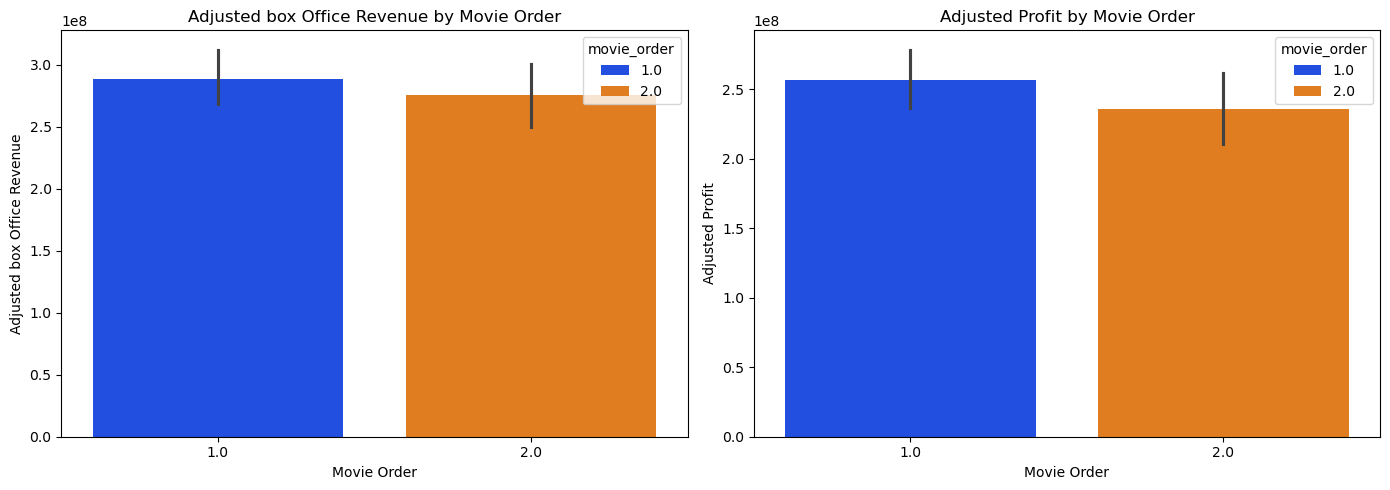

T-test Results:
T-statistic of box-office: nan ; T-statistic of profit: nan
P-value of box-office: nan ; P-value of profit: nan
The difference in means is not statistically significant (p >= 0.05).


In [34]:
# Extract the mean box office revenue for the first and second movies
first_movie_revenue = f_and_s[f_and_s['movie_order'] == 1]['real_revenue']
second_movie_revenue = f_and_s[f_and_s['movie_order'] == 2]['real_revenue']

first_movie_profit = f_and_s[f_and_s['movie_order'] == 1]['real_profit']
second_movie_profit = f_and_s[f_and_s['movie_order'] == 2]['real_profit']

# Do side by side barplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x="movie_order", y="real_revenue", data=f_and_s, palette='bright', hue='movie_order', ax=ax1)
ax1.set_ylabel('Adjusted box Office Revenue')
ax1.set_xlabel('Movie Order')
ax1.set_title('Adjusted box Office Revenue by Movie Order')

sns.barplot(x="movie_order", y="profit", data=f_and_s, palette='bright',hue='movie_order', ax=ax2)
ax2.set_ylabel('Adjusted Profit')
ax2.set_xlabel('Movie Order')
ax2.set_title('Adjusted Profit by Movie Order')

plt.tight_layout()
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat1, p_value1 = stats.ttest_ind(first_movie_revenue, second_movie_revenue, equal_var=False)
t_stat2, p_value2 = stats.ttest_ind(first_movie_profit, second_movie_profit, equal_var=False)
print("T-test Results:")
print(f"T-statistic of box-office: {t_stat1:.4f} ; T-statistic of profit: {t_stat2:.4f}")
print(f"P-value of box-office: {p_value1:.4e} ; P-value of profit: {p_value2:.4e}")
if p_value1 and p_value2 < 0.05:
    print("The difference in box-office and profit means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

## Time representation

## Countries repartition

## Character data analysis 

# Bivariate analysis 

## Movie revenue and budget 

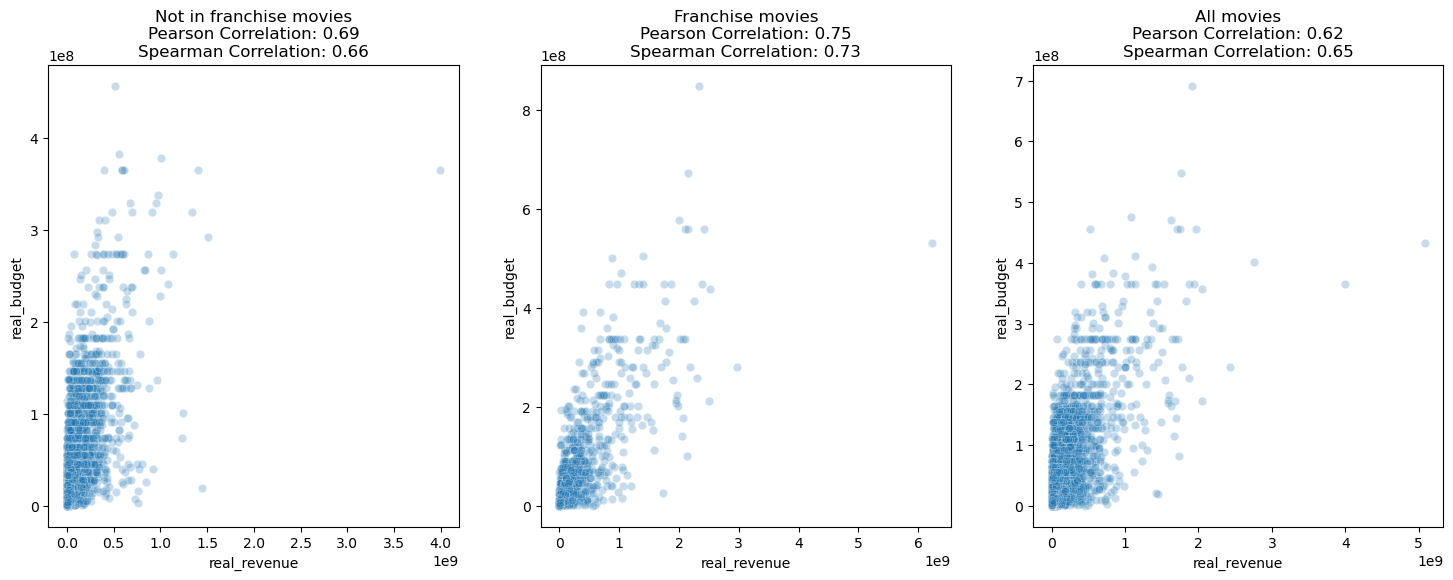

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget',data=movies_no_franchise_revenue,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=franchise_revenue,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=movies_revenue,alpha=.25, ax=axes[2])
# Calculate Pearson correlation

pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

axes[0].set_title(f'Not in franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[0,1]:.2f}')
axes[1].set_title(f'Franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[1,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[1,1]:.2f}')
axes[2].set_title(f'All movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[2,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[2,1]:.2f}');


## Genre and revenue

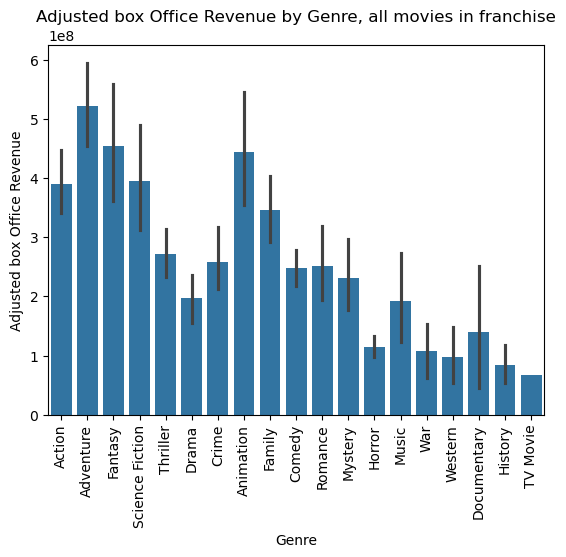

In [32]:
# add profit column
franchise_df['profit'] = franchise_df['real_revenue'] - franchise_df['real_budget']

# Explode the genres column so that each genre gets its own row
exploded_df = franchise_df.explode('genres').reset_index(drop=True).sort_values(by='real_revenue', ascending=False)

ax = sns.barplot(x="genres", y="real_revenue", data=exploded_df)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()
#print(exploded_df.groupby('genres')['real_revenue'].describe())

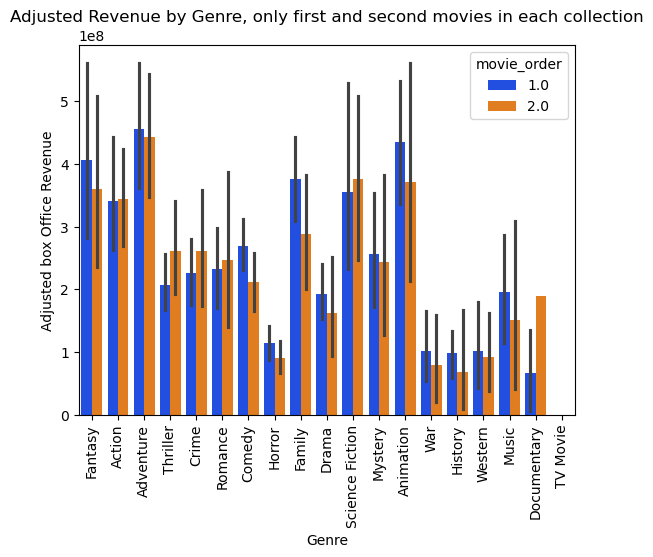

In [33]:
f_and_s = exploded_df[exploded_df['movie_order'].isin([1.0, 2.0])] # First and second movies in each collection
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s.sort_values(by='real_revenue', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()

Here, we notice that TV Movies don't have a barplot, as only one movie in a franchise has the real revenue, and it is the third movie in its franchise. Lack of error bars means not enough info

In [18]:
'''all_box2= pd.DataFrame({
        'non-franchise movies': movies_df['real_revenue'], #movie_box['Movie box office revenue'],
        'franchise second movies': second_movie_profit # box_office_df['Movie box office revenue']
        })

all_box2.plot(kind='bar', figsize=(10, 5))
plt.ylabel('Adjusted Profit')
plt.xlabel('Genre')
plt.title('Adjusted Profit by Genre, and order')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()'''

"all_box2= pd.DataFrame({\n        'non-franchise movies': movies_df['real_revenue'], #movie_box['Movie box office revenue'],\n        'franchise second movies': second_movie_profit # box_office_df['Movie box office revenue']\n        })\n\nall_box2.plot(kind='bar', figsize=(10, 5))\nplt.ylabel('Adjusted Profit')\nplt.xlabel('Genre')\nplt.title('Adjusted Profit by Genre, and order')\nplt.xticks(rotation=90)  # Rotate x-axis labels for better readability\nplt.show()"

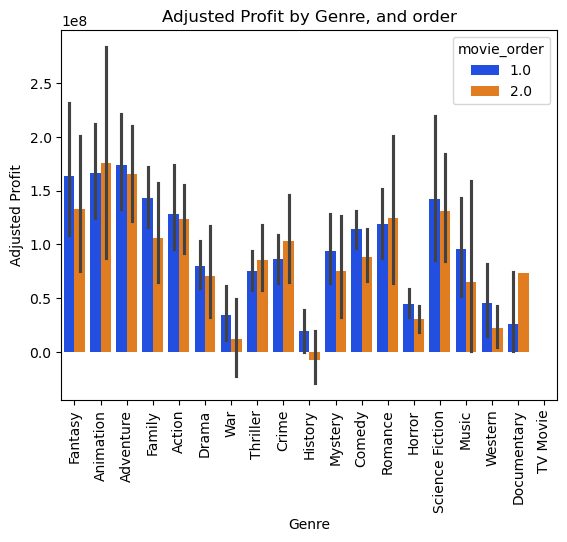

In [19]:
ax = sns.barplot(x="genres", y="real_profit", data=f_and_s.sort_values(by='real_profit', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted Profit')
plt.xlabel('Genre')
plt.title('Adjusted Profit by Genre, and order')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Same thing here

## Budget and revenue

# Supervised learning

## First and Second movie

### Linear Regression 

### Tree  --> WE need a non continuous variable a new feature such as good or not good 2 nd movie 

In [20]:
# %%
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

# %%
def count_genre_diff(curr, prev):
    if curr is None or prev is None:  # Handle NaN or None
        return 0
    curr_set, prev_set = set(curr), set(prev)
    return len(curr_set.symmetric_difference(prev_set))  # Count differences

# Apply the function while ensuring sorting
franchise_df['genre_diff'] = (
    franchise_df.groupby('collection_id', group_keys=False)
    .apply(
        lambda group: group.sort_values(by='movie_order')  # Sort locally
        .assign(
            genre_diff=lambda x: [
                count_genre_diff(curr, prev)
                for curr, prev in zip(x['genres'], x['genres'].shift(1))
            ]
        )
    )['genre_diff']  # Extract the 'genre_diff' column
    .reset_index(drop=True)  # Reset index to avoid misalignment
)

# difference relative de genre
franchise_df['genre_diff_rel'] = franchise_df['genre_diff'] / franchise_df['genres'].apply(len)

# %%
# analysis of the difference between the first en second movies
fsm_df = franchise_df[(franchise_df['movie_order'] == 1) | (franchise_df['movie_order'] == 2)]
fsm_df = fsm_df[['Movie name','collection_name','movie_order','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies','genre_diff','genre_diff_rel']]
fsm_df.sort_values(by='movie_order',inplace=True)
fsm_df['diff_profit_1_2'] = fsm_df.groupby('collection_name')['real_profit'].diff()
fsm_df['diff_budget_1_2'] = fsm_df.groupby('collection_name')['real_budget'].diff()
fsm_df['diff_revenue_1_2'] = fsm_df.groupby('collection_name')['real_revenue'].diff()
sm_df = fsm_df[fsm_df['movie_order'] == 2]
sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']
sm_df=sm_df[sm_df['diff_profit_1_2'].notna()]  
X = sm_df[['real_budget','years_diff_bt_pre_movies','diff_budget_1_2','genre_diff']]
X = pd.get_dummies(X, columns=['genre_diff'], drop_first=True)

Y = sm_df['profit_over_budget'] 



/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_18093/3625562519.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_18093/3625562519.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']


In [21]:
# %%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [22]:
# Define the bins and labels
bins = [-np.inf, -1, 0, 1, 2, 5, 10, np.inf]
labels = ['Very Low', 'Low', 'Below Average', 'Average', 'Above Average', 'High', 'Very High']

# Transform Y into non-continuous values
Y_binned = pd.cut(y_train, bins=bins, labels=labels)

# Print the transformed Y
print(Y_binned)
print(y_train)

136         Very High
247     Below Average
654     Below Average
484     Below Average
50          Very High
            ...      
530     Below Average
4577    Below Average
427     Above Average
927     Below Average
364     Below Average
Name: profit_over_budget, Length: 199, dtype: category
Categories (7, object): ['Very Low' < 'Low' < 'Below Average' < 'Average' < 'Above Average' < 'High' < 'Very High']
136     12.316484
247      0.066655
654      0.492085
484      0.300642
50      12.902139
          ...    
530      0.185794
4577     0.591640
427      2.758881
927      0.653369
364      0.060665
Name: profit_over_budget, Length: 199, dtype: float64


In [23]:
# %%
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state=42)

decision_tree_classifier.fit(X_train, Y_binned)

y_test_pred_rf = decision_tree_classifier.predict(X_test)

#acc = accuracy_fn(y_test, y_test_pred_rf)
depth = decision_tree_classifier.get_depth()
#print(f"Accuracy: {acc}, Depth: {depth}")   

# Visualize the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 100))
plot_tree(decision_tree_classifier, filled=True)
plt.show()
